## Database Formation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
from sqlite3 import Error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

In [255]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [221]:
def extract_data(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            data.append(line)
    return data

def insert_into_table(conn,values,sql_statement):
    sql = sql_statement
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

In [222]:
norm = create_connection('norm_db')

In [223]:
conn = extract_data('AADT_Counts.csv')
vals = conn[1:]

#### Creating County Table

In [224]:
lst = [line.split(',')[1] for line in vals]
county = sorted(list(set(lst)))

create_table_sql = """CREATE TABLE IF NOT EXISTS [County] (
    [CountyID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    [County] TEXT NOT NULL 
);
"""
create_table(norm, create_table_sql,'County')

sql_statement = ''' INSERT INTO County (County)
                    VALUES(?) '''


with norm:
    for c in county:
        insert_into_table(norm, (c, ), sql_statement)

In [225]:
sql_statement = 'SELECT * FROM County'
data = execute_sql_statement(sql_statement, norm)

cnt_id = list(map(lambda row: row[0], data))
cnt = list(map(lambda row: row[1].strip(), data))

cnt_dict = {key : value for key,value in zip(cnt,cnt_id)}

In [226]:
cnt_dict

{'Chautauqua': 1, 'Erie': 2, 'Niagara': 3}

#### Creating Municipality Table

In [227]:
combos = []
with open('AADT_Counts.csv') as file:
    header = None
    for line in file:
        if not line.strip():
            continue
        if not header:
            header = line.strip().split(',')
            continue
        data = line.strip().split(',')
        
        mcp = data[2]
        
        cnt = data[1]

        combo = tuple((mcp,cnt_dict[cnt]))
        if combo not in combos:
            combos.append(combo)

municipality = sorted(combos, key=lambda ele: ele[0])

create_table_sql = """CREATE TABLE IF NOT EXISTS [Municipality] (
    [MunicipalityID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    [Municipality] TEXT NOT NULL,
    [CountyID] INTEGER NOT NULL,
    FOREIGN KEY(CountyID) REFERENCES County(CountyID)
);
"""

create_table(norm, create_table_sql,'Municipality')

sql_statement = ''' INSERT INTO Municipality (Municipality, CountyID)
                    VALUES(?,?) '''

with norm:
    for m,c in municipality:
        insert_into_table(norm, (m,c), sql_statement)


In [228]:
sql_statement = 'SELECT MunicipalityID,Municipality FROM Municipality'
data = execute_sql_statement(sql_statement, norm)

mun_id = list(map(lambda row: row[0], data))
mun = list(map(lambda row: row[1].strip(), data))

mun_dict = {key : value for key,value in zip(mun,mun_id)}

#### Creating Local Table

In [229]:
combos = []
with open('AADT_Counts.csv') as file:
    header = None
    for line in file:
        if not line.strip():
            continue
        if not header:
            header = line.strip().split(',')
            continue
        data = line.strip().split(',')
        
        l_id = data[0]
        
        cnt = data[1]
        mcp = data[2]

        combo = tuple((l_id,cnt_dict[cnt],mun_dict[mcp]))
        if combo not in combos:
            combos.append(combo)
            
local = sorted(combos, key=lambda ele: ele[0])

create_table_sql = """CREATE TABLE IF NOT EXISTS [Local] (
    [LocalID] TEXT NOT NULL PRIMARY KEY,
    [CountyID] INTEGER NOT NULL,
    [MunicipalityID] INTEGER NOT NULL,
    FOREIGN KEY(CountyID) REFERENCES County(CountyID)
    FOREIGN KEY(MunicipalityID) REFERENCES Municipality(MunicipalityID)
);
"""

create_table(norm, create_table_sql,'Local')

sql_statement = ''' INSERT INTO Local (LocalID, CountyID,MunicipalityID)
                    VALUES(?,?,?) '''

with norm:
    for l,c,m in local:
        insert_into_table(norm, (l,c,m), sql_statement)


#### Creating Roads Table

In [230]:
combos = []
with open('AADT_Counts.csv') as file:
    header = None
    for line in file:
        if not line.strip():
            continue
        if not header:
            header = line.strip().split(',')
            continue
        data = line.strip().split(',')
        
        l_id = data[0]
        on = data[3]
        frm = data[4]
        to = data[5]

        combo = tuple((l_id,on,frm,to))
        combos.append(combo)

roads = sorted(combos, key=lambda ele: ele[0])

create_table_sql = """CREATE TABLE IF NOT EXISTS [Roads] (
    [LocalID] TEXT NOT NULL PRIMARY KEY,
    [Road_name] TEXT NOT NULL,
    [Start_point] TEXT NOT NULL,
    [End_point] TEXT NOT NULL,
    FOREIGN KEY(LocalID) REFERENCES Local(LocalID)
);
"""

create_table(norm, create_table_sql,'Roads')

sql_statement = ''' INSERT INTO Roads (LocalID, Road_name,Start_point,End_point)
                    VALUES(?,?,?,?) '''

with norm:
    for l,o,f,t in roads:
        insert_into_table(norm, (l,o,f,t), sql_statement)


IntegrityError: UNIQUE constraint failed: Roads.LocalID

#### Creating AADT Table

In [231]:
combos = []
with open('AADT_Counts.csv') as file:
    header = None
    for line in file:
        if not line.strip():
            continue
        if not header:
            header = line.strip().split(',')
            continue
        data = line.strip().split(',')
        
        l_id = data[0]
        year = data[8]
        aadt = data[9]

        combo = tuple((l_id,year,aadt))
        combos.append(combo)

info = sorted(combos, key=lambda ele: (ele[0],ele[1]))

create_table_sql = """CREATE TABLE IF NOT EXISTS [AADT] (
    [LocalID] TEXT NOT NULL PRIMARY KEY,
    [Year] INTEGER NOT NULL,
    [AADT] INTEGER NOT NULL,
    FOREIGN KEY(LocalID) REFERENCES Local(LocalID)
);
"""

create_table(norm, create_table_sql,'AADT')

sql_statement = ''' INSERT INTO AADT (LocalID, Year,AADT)
                    VALUES(?,?,?) '''

with norm:
    for l,y,a in info:
        insert_into_table(norm, (l,y,a), sql_statement)


IntegrityError: UNIQUE constraint failed: AADT.LocalID

## Table Extraction

In [180]:
table = pd.read_csv('AADT_Counts.csv')
table

,Local ID,County,Municipality,On,From,To,Approach,Direction,AADT Year,AADT
0,536054,Erie,Amherst,I-290 @ I-990,NaN,NaN,NaN,RAMP,2012.0,14467.0
1,537024,Erie,Collins,Erie Ave,Park St,Vill Ln,NaN,2-WAY,2011.0,250.0
2,534468,Erie,Elma,Jamison Rd,Schultz Rd,Girdle Rd,NaN,2-WAY,1990.0,4600.0
3,544219,Niagara,Lockport,Stone Rd,Ny 104,Sunset Dr,NaN,2-WAY,2008.0,2200.0
4,533027,Erie,Cheektowaga,I-90 @ Exit 53 I-190,NaN,NaN,NaN,RAMP,2013.0,25439.0
...,...,...,...,...,...,...,...,...,...,...
23377,540030,Niagara,Lewiston,Second St (Rt 18F),Oneida St,Lewiston N Vill Ln,NaN,2-WAY,2007.0,2850.0
23378,534021,Erie,Buffalo,Amherst St,Rt 265 Military Rd,Grant St,NaN,2-WAY,2014.0,5549.0
23379,530251,Erie,Buffalo,South Park Ave,Buffalo S City Ln,Tifft St,BETWEEN,2-WAY,2005.0,12170.0
23380,543034,Niagara,Lewiston,Ny 104 / Rmsp,NaN,NaN,NaN,RAMP,2009.0,363.0


In [181]:
table.drop(['Approach','Direction'],axis = 1, inplace = True)

In [182]:
table

,Local ID,County,Municipality,On,From,To,AADT Year,AADT
0,536054,Erie,Amherst,I-290 @ I-990,NaN,NaN,2012.0,14467.0
1,537024,Erie,Collins,Erie Ave,Park St,Vill Ln,2011.0,250.0
2,534468,Erie,Elma,Jamison Rd,Schultz Rd,Girdle Rd,1990.0,4600.0
3,544219,Niagara,Lockport,Stone Rd,Ny 104,Sunset Dr,2008.0,2200.0
4,533027,Erie,Cheektowaga,I-90 @ Exit 53 I-190,NaN,NaN,2013.0,25439.0
...,...,...,...,...,...,...,...,...
23377,540030,Niagara,Lewiston,Second St (Rt 18F),Oneida St,Lewiston N Vill Ln,2007.0,2850.0
23378,534021,Erie,Buffalo,Amherst St,Rt 265 Military Rd,Grant St,2014.0,5549.0
23379,530251,Erie,Buffalo,South Park Ave,Buffalo S City Ln,Tifft St,2005.0,12170.0
23380,543034,Niagara,Lewiston,Ny 104 / Rmsp,NaN,NaN,2009.0,363.0


In [183]:
table.drop_duplicates()

,Local ID,County,Municipality,On,From,To,AADT Year,AADT
0,536054,Erie,Amherst,I-290 @ I-990,NaN,NaN,2012.0,14467.0
1,537024,Erie,Collins,Erie Ave,Park St,Vill Ln,2011.0,250.0
2,534468,Erie,Elma,Jamison Rd,Schultz Rd,Girdle Rd,1990.0,4600.0
3,544219,Niagara,Lockport,Stone Rd,Ny 104,Sunset Dr,2008.0,2200.0
4,533027,Erie,Cheektowaga,I-90 @ Exit 53 I-190,NaN,NaN,2013.0,25439.0
...,...,...,...,...,...,...,...,...
23377,540030,Niagara,Lewiston,Second St (Rt 18F),Oneida St,Lewiston N Vill Ln,2007.0,2850.0
23378,534021,Erie,Buffalo,Amherst St,Rt 265 Military Rd,Grant St,2014.0,5549.0
23379,530251,Erie,Buffalo,South Park Ave,Buffalo S City Ln,Tifft St,2005.0,12170.0
23380,543034,Niagara,Lewiston,Ny 104 / Rmsp,NaN,NaN,2009.0,363.0


In [184]:
table.describe(include='all')

,Local ID,County,Municipality,On,From,To,AADT Year,AADT
count,23382,23382,23382,23382,22510,22510,23347.000000,23347.000000
unique,4133,3,87,1586,1728,1728,NaN,NaN
top,530014,Erie,Buffalo,Main St,Rt 5 Main St,Rt 5 Main St,NaN,NaN
freq,39,17177,5298,417,261,336,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2000.624534,10176.713325
std,NaN,NaN,NaN,NaN,NaN,NaN,12.328277,13863.541315
min,NaN,NaN,NaN,NaN,NaN,NaN,1971.000000,13.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1991.000000,2884.500000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2004.000000,6300.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,12000.000000


In [185]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23382 entries, 0 to 23381
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Local ID      23382 non-null  object 
 1   County        23382 non-null  object 
 2   Municipality  23382 non-null  object 
 3   On            23382 non-null  object 
 4   From          22510 non-null  object 
 5   To            22510 non-null  object 
 6   AADT Year     23347 non-null  float64
 7   AADT          23347 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.4+ MB


In [186]:
dtf = table[~table.On.str.contains('|'.join('@'))]
df = dtf[~dtf.On.str.contains('|'.join('"'))]

In [187]:
round(df.describe(include = 'all'),2)

,Local ID,County,Municipality,On,From,To,AADT Year,AADT
count,22719,22719,22719,22719,22510,22510,22684.00,22684.00
unique,3761,3,87,1502,1728,1728,NaN,NaN
top,540050,Erie,Buffalo,Main St,Rt 5 Main St,Rt 5 Main St,NaN,NaN
freq,39,16609,5122,417,261,336,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2000.30,10324.43
std,NaN,NaN,NaN,NaN,NaN,NaN,12.35,14014.16
min,NaN,NaN,NaN,NaN,NaN,NaN,1971.00,13.00
25%,NaN,NaN,NaN,NaN,NaN,NaN,1991.00,2900.00
50%,NaN,NaN,NaN,NaN,NaN,NaN,2003.00,6400.00
75%,NaN,NaN,NaN,NaN,NaN,NaN,2011.00,12200.00


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22719 entries, 1 to 23381
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Local ID      22719 non-null  object 
 1   County        22719 non-null  object 
 2   Municipality  22719 non-null  object 
 3   On            22719 non-null  object 
 4   From          22510 non-null  object 
 5   To            22510 non-null  object 
 6   AADT Year     22684 non-null  float64
 7   AADT          22684 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.6+ MB


In [189]:
df['AADT'].unique()

array([  250.,  4600.,  2200., ...,  5549., 12170.,   363.])

<AxesSubplot:xlabel='AADT', ylabel='Count'>

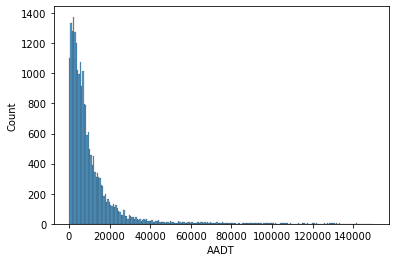

In [190]:
sns.histplot(df['AADT'])

<AxesSubplot:xlabel='AADT', ylabel='County'>

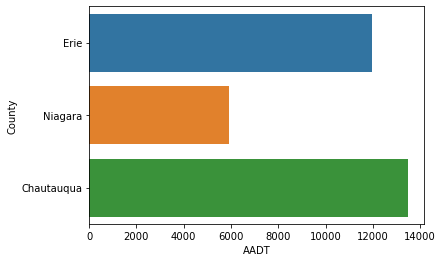

In [191]:
sns.barplot(x = df.AADT, y = df.County, ci = False)

<AxesSubplot:xlabel='AADT Year', ylabel='Count'>

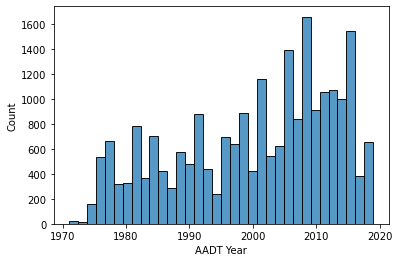

In [192]:
sns.histplot(df['AADT Year'])

In [193]:
df

,Local ID,County,Municipality,On,From,To,AADT Year,AADT
1,537024,Erie,Collins,Erie Ave,Park St,Vill Ln,2011.0,250.0
2,534468,Erie,Elma,Jamison Rd,Schultz Rd,Girdle Rd,1990.0,4600.0
3,544219,Niagara,Lockport,Stone Rd,Ny 104,Sunset Dr,2008.0,2200.0
5,535117,Erie,Cheektowaga,St. Lucia Ln,Zoerb Ave,S Creek Dr,2014.0,133.0
6,530190,Erie,Hamburg,South Park Ave,N Vill Ln,Rt 20 Southwestern Blvd,1990.0,12500.0
...,...,...,...,...,...,...,...,...
23377,540030,Niagara,Lewiston,Second St (Rt 18F),Oneida St,Lewiston N Vill Ln,2007.0,2850.0
23378,534021,Erie,Buffalo,Amherst St,Rt 265 Military Rd,Grant St,2014.0,5549.0
23379,530251,Erie,Buffalo,South Park Ave,Buffalo S City Ln,Tifft St,2005.0,12170.0
23380,543034,Niagara,Lewiston,Ny 104 / Rmsp,NaN,NaN,2009.0,363.0


In [194]:
df1 = df[['Local ID','County','Municipality','On','From','To']]
df1

,Local ID,County,Municipality,On,From,To
1,537024,Erie,Collins,Erie Ave,Park St,Vill Ln
2,534468,Erie,Elma,Jamison Rd,Schultz Rd,Girdle Rd
3,544219,Niagara,Lockport,Stone Rd,Ny 104,Sunset Dr
5,535117,Erie,Cheektowaga,St. Lucia Ln,Zoerb Ave,S Creek Dr
6,530190,Erie,Hamburg,South Park Ave,N Vill Ln,Rt 20 Southwestern Blvd
...,...,...,...,...,...,...
23377,540030,Niagara,Lewiston,Second St (Rt 18F),Oneida St,Lewiston N Vill Ln
23378,534021,Erie,Buffalo,Amherst St,Rt 265 Military Rd,Grant St
23379,530251,Erie,Buffalo,South Park Ave,Buffalo S City Ln,Tifft St
23380,543034,Niagara,Lewiston,Ny 104 / Rmsp,NaN,NaN


In [195]:
C_dummies = pd.get_dummies(df.County)  
M_dummies = pd.get_dummies(df.Municipality)
O_dummies = pd.get_dummies(df.On)
F_dummies = pd.get_dummies(df.From)
T_dummies = pd.get_dummies(df.To)   
T_dummies    

,10Th St,11Th St,18 Mile Creek Bridge (Town Line),18Th Ave,18Th St,19Th St,1St St,22Nd St,24Th St,27Th St,...,Wyoming Co Ln,Young St,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
merged = pd.concat([df,C_dummies,M_dummies,O_dummies,F_dummies,T_dummies],axis=1)  
merged
df = merged.drop(['County','Municipality','On','From','To','Chautauqua','Akron','10Th St','10Th St','10Th St'], axis = 1)


In [197]:
df

,Local ID,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,...,Wyoming Co Ln,Young St,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave
1,537024,2011.0,250.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,534468,1990.0,4600.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,544219,2008.0,2200.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,535117,2014.0,133.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,530190,1990.0,12500.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23377,540030,2007.0,2850.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23378,534021,2014.0,5549.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23379,530251,2005.0,12170.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23380,543034,2009.0,363.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
df.drop('Local ID',axis = 1,inplace=True)
# df.drop('LocalID',axis = 1,inplace=True)

In [199]:
df

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Wyoming Co Ln,Young St,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave
1,2011.0,250.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1990.0,4600.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2008.0,2200.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2014.0,133.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1990.0,12500.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23377,2007.0,2850.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23378,2014.0,5549.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23379,2005.0,12170.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23380,2009.0,363.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
df.isnull().sum()

AADT Year         35
AADT              35
Erie               0
Niagara            0
Alden              0
                  ..
Yvonne Ave         0
Zimmerman Rd       0
Zimmerman St       0
Zoar Valley Rd     0
Zollars Ave        0
Length: 5045, dtype: int64

In [201]:
35/22719

0.001540560764118139

In [202]:
df.dropna(inplace = True)

In [203]:
df

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Wyoming Co Ln,Young St,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave
1,2011.0,250.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1990.0,4600.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2008.0,2200.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2014.0,133.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1990.0,12500.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23377,2007.0,2850.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23378,2014.0,5549.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23379,2005.0,12170.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23380,2009.0,363.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [204]:
X = StandardScaler()
scaled_df = X.fit_transform(df)

In [205]:
k_means = KMeans(n_clusters = 2)
k_means.fit(scaled_df)
k_means.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [206]:
k_means.inertia_

113419955.26961179

In [207]:
k_means = KMeans(n_clusters = 3)
k_means.fit(scaled_df)
k_means.inertia_

113372224.42587587

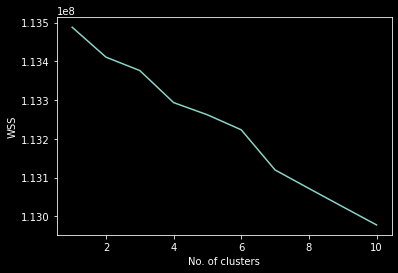

In [229]:
wss = []
fig = plt.figure()
plt.style.use('dark_background')

for i in range(1,11):
    KM = KMeans(n_clusters=i)
    KM.fit(scaled_df)
    wss.append(KM.inertia_)

plt.xlabel('No. of clusters')
plt.ylabel('WSS')
plt.plot(range(1,11), wss)

##### optimum number of clusters = 4

In [209]:
k_means = KMeans(n_clusters = 4)
k_means.fit(scaled_df)
labels = k_means.labels_

In [210]:
df["Cluster"] = labels

In [211]:
silhouette_score(scaled_df,labels)

0.025123853854934784

In [212]:
sil_width = silhouette_samples(scaled_df,labels)

In [213]:
df["sil_width"] = silhouette_samples(scaled_df,labels)

In [214]:
df

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave,Cluster,sil_width
1,2011.0,250.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,-0.000969
2,1990.0,4600.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.017741
3,2008.0,2200.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.005854
5,2014.0,133.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,-0.000960
6,1990.0,12500.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.036123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23377,2007.0,2850.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.010390
23378,2014.0,5549.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.051064
23379,2005.0,12170.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.024460
23380,2009.0,363.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.027141


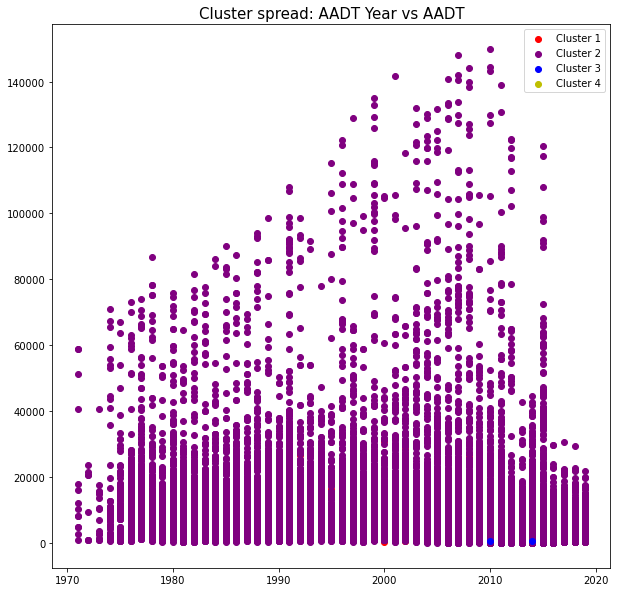

In [215]:
v_labels=((1,'Cluster 1','r'), (2,'Cluster 2','purple'),(3,'Cluster 3','b'), (4,'Cluster 4','y'))
plt.figure(figsize=(10,10))
for (n,i,j) in v_labels:
    plt.scatter(df[df.Cluster==n]['AADT Year'], df[df.Cluster==n]['AADT'],c=j, label=i)
    
plt.legend()
plt.title('Cluster spread: AADT Year vs AADT', size=15)
plt.show()

In [216]:
df[df.Cluster == 1]['AADT Year']

3        2008.0
10       1998.0
71       1982.0
129      2014.0
141      2012.0
          ...  
23312    1976.0
23328    2018.0
23340    1996.0
23343    2018.0
23344    2008.0
Name: AADT Year, Length: 1073, dtype: float64

In [217]:
df[df.Cluster==1]['AADT']

3         2200.0
10        1400.0
71       13100.0
129       6213.0
141       2505.0
          ...   
23312     2800.0
23328     7451.0
23340    13000.0
23343     1285.0
23344     3000.0
Name: AADT, Length: 1073, dtype: float64

Text(0.5, 1.0, 'Cluster 1')

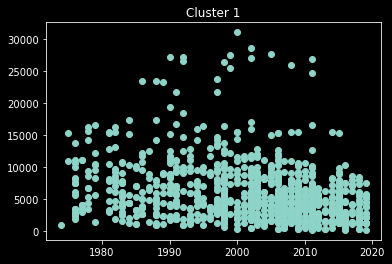

In [230]:
plt.style.use('dark_background')
plt.scatter(df[df.Cluster == 1]['AADT Year'],df[df.Cluster==1]['AADT'],label = 'Cluster 1')
plt.title('Cluster 1')

Text(0.5, 1.0, 'Cluster 2')

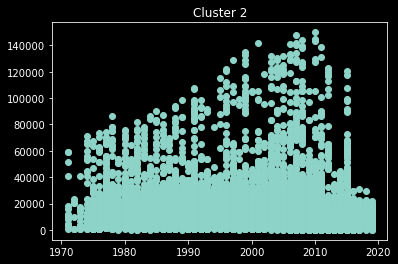

In [231]:
plt.style.use('dark_background')
plt.scatter(df[df.Cluster == 2]['AADT Year'],df[df.Cluster==2]['AADT'],label = 'Cluster 2')
plt.title('Cluster 2')

Text(0.5, 1.0, 'Cluster 3')

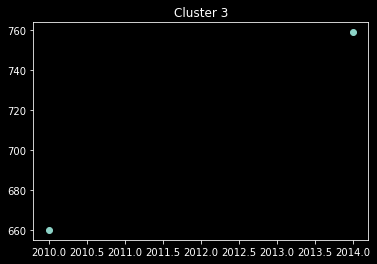

In [232]:
plt.style.use('dark_background')
plt.scatter(df[df.Cluster == 3]['AADT Year'],df[df.Cluster==3]['AADT'],label = 'Cluster 2')
plt.title('Cluster 3')

Text(0.5, 1.0, 'Cluster 4')

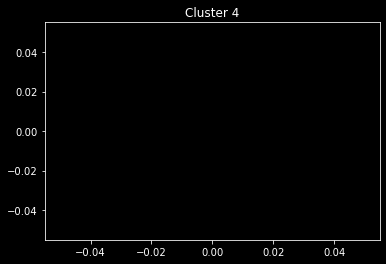

In [233]:
plt.style.use('dark_background')
plt.scatter(df[df.Cluster == 4]['AADT Year'],df[df.Cluster==4]['AADT'],label = 'Cluster 2')
plt.title('Cluster 4')

In [222]:
df[df.Cluster==1]

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave,Cluster,sil_width
3,2008.0,2200.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.005854
10,1998.0,1400.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.021328
71,1982.0,13100.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.004213
129,2014.0,6213.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.010258
141,2012.0,2505.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.005830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23312,1976.0,2800.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.007083
23328,2018.0,7451.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.000985
23340,1996.0,13000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.016886
23343,2018.0,1285.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.002353


In [223]:
df[df.Cluster==2]

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave,Cluster,sil_width
1,2011.0,250.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,-0.000969
2,1990.0,4600.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.017741
5,2014.0,133.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,-0.000960
6,1990.0,12500.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.036123
7,1979.0,2900.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.017424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23377,2007.0,2850.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.010390
23378,2014.0,5549.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.051064
23379,2005.0,12170.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.024460
23380,2009.0,363.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.027141


In [224]:
df[df.Cluster==3]

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave,Cluster,sil_width
14050,2010.0,660.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0.99805
19549,2014.0,759.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0.99805


In [225]:
df[df.Cluster==4]

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave,Cluster,sil_width


In [226]:
df[df.Cluster==5]

,AADT Year,AADT,Erie,Niagara,Alden,Amherst,Amherst/Buffalo,Amherst/Tonawanda,Angola,Aurora,...,Youngs Rd,Youngstown Rd,Youngstown S Vill Ln,Yvonne Ave,Zimmerman Rd,Zimmerman St,Zoar Valley Rd,Zollars Ave,Cluster,sil_width
